# I. Introduction
Determin Porygon DT of Sampled Users to Each Restaurant




# II. Preparation

## 2.1 install & load packages

In [1]:
%%capture
# install packages
!pip install folium
!pip install geopandas

In [2]:
# load packages
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import TimestampedGeoJson
from folium import plugins
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
import geopandas
from shapely import wkt
%matplotlib inline
#from google.colab import drive # to allow colab save file in my drive
#drive.mount('drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authenticated
The google.colab.data_table extension is not loaded.


## 2.2 Create temp tables

We get the data from big query "fulfillment-dwh-production". 

First you need to define in which country, which city and which vehicle_profile and which analytical period you want it to run. 

Second, you run the query to create table

Third, you request the table data as a data frame.

In [12]:
# define some variables
project_id = "fulfillment-dwh-production"
entity_id = "FP_SG" 
#city_id = "200"
#vehicle_profile = "default"
geohash_digit = "4"
#analytical period
start_date = "2020-08-01"
end_date = "2020-08-01"

# define project id
client = bigquery.Client(project = project_id)

#print("This script will return price points result in a table for {a} as vehicle profile with {b}-digit geohash in City {c} of Country {d}".format(a=vehicle_profile_tbd, b=geohash_digit, c=city_id_tbd, d=country_code_tbd))

In [29]:
#@title Bigquery script to create temp tables
# Create temp tables 
query = """
-- zone_temp to get basic zone table information
drop table if exists `temp.vendor_""" + entity_id + """`;
CREATE TABLE `temp.vendor_""" + entity_id + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	WITH city_data AS (
  SELECT p.entity_id
    , country_code
    , ci.name AS city_name
    , ci.id AS city_id
    , zo.shape AS zone_shape 
    , zo.name AS zone_name
    , zo.id AS zone_id
  FROM cl.countries co
  LEFT JOIN UNNEST(co.platforms) p
  LEFT JOIN UNNEST(co.cities) ci
  LEFT JOIN UNNEST(ci.zones) zo
  WHERE country_code IS NOT NULL
)
  SELECT v.entity_id
    , v.vendor_code
      , cd.country_code
			, cd.city_id
			, cd.city_name
      , cd.zone_name
      , zone_id
			, st_x(v.location) as res_long
			, st_y(v.location) as res_lat
      , st_astext(h.shape) as das_shape
  FROM cl.vendors_v2 v
  LEFT JOIN city_data cd ON v.entity_id = cd.entity_id
	LEFT JOIN unnest(delivery_areas) de
  LEFT JOIN unnest(history) h
  WHERE ST_CONTAINS(cd.zone_shape, v.location) IS TRUE
    and v.entity_id = \"""" + entity_id + """\" 
		and v.is_active
		and h.active_to is null
		and de.is_deleted = False
  GROUP BY 1,2,3,4,5,6,7,8,9,10
 );

-- geohash
drop table if exists `temp.user_geohash_""" + entity_id + """`;
CREATE TABLE `temp.user_geohash_""" + entity_id + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
select
		st_geohash(customer.location,""" + geohash_digit + """) as geohash, 
    zone_id as user_zone_id,
		o.city_id as user_city_id,
    count(distinct platform_order_code) as weight
	from `fulfillment-dwh-production.cl.orders` o
  left join unnest(deliveries) d
	where entity.id = \"""" + entity_id + """\" 
		and zone_id is not null
		and cast(order_placed_at as date) between \"""" + start_date + """\"  and \"""" + end_date + """\" 
    and o.order_status = 'completed'
    and d.delivery_status = 'completed'
  group by 1,2,3);

drop table if exists `temp.result_""" + entity_id + """`;
CREATE TABLE `temp.result_""" + entity_id + """`
OPTIONS(
	  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
	) as (
	select
		geohash,
		st_astext(ST_GEOGPOINTFROMGEOHASH(geohash)) as geohash_center,
    vendor_code,
    res_long,
    res_lat,
    city_id,
    city_name,
    zone_id,
    zone_name,
		st_distance(ST_GEOGPOINTFROMGEOHASH(geohash), st_geogpoint(res_long, res_lat)) as delivery_distance,
    avg(weight) as weight
  from temp.user_geohash_""" + entity_id + """ u
	cross join temp.vendor_""" + entity_id + """ v
	where u.user_zone_id = v.zone_id and u.user_city_id = v.city_id
  and st_intersects(st_geogfromtext(das_shape), ST_GEOGPOINTFROMGEOHASH(geohash))
  group by 1,2,3,4,5,6,7,8,9);
"""

query_job = client.query(query)  # Make an API request.
results = query_job.result()


In [30]:
query2 = """
SELECT
    a.*
    , st_x(st_geogfromtext(geohash_center)) as geohash_long
    , st_y(st_geogfromtext(geohash_center)) as geohash_lat
  FROM
    `temp.results_""" + entity_id + """` a
    """

df = client.query(query2).to_dataframe()
df.head()

NotFound: ignored

## 2.3 Select relevant zones

In [ ]:
# all the zone ids for the country
zone_id = df.user_zone_id.unique()
zone_id = zone_id.tolist()
zone_id

[27,
 64,
 45,
 59,
 63,
 50,
 19,
 35,
 65,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 10,
 16,
 29,
 30,
 32,
 33,
 36,
 40,
 41,
 42,
 44,
 46,
 51,
 52,
 53,
 54,
 70,
 49,
 25,
 37,
 28,
 67,
 12,
 20,
 55,
 75,
 34,
 74,
 48,
 9,
 23,
 47,
 56,
 62,
 71,
 72,
 31,
 5,
 17,
 68,
 66,
 22,
 38,
 24,
 43,
 39,
 61,
 58,
 60]

**IMPORTANT:** about choosing zones!

If you want to choose all zones, then you need to do nothing
If you want to choose one zone or more thatn one zones, then remove the "#" and put the zone_ids in the branket and run the script 

In [ ]:
# zone_id = [33, 29]
df_zone = df[df["user_zone_id"].isin(zone_id)]

# III. Insight
This script offers 3 insights

In [ ]:
pivot=df_zone.pivot_table("restaurant_id", index=['geohash_center',"geohash","weight"], columns='porygon_dt', aggfunc='count')
totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot

,,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40
geohash_center,geohash,weight,,,,,,,,,,,,,,,,,,,,,,,,
POINT(113.920669555664 22.2946929931641),wecnb6d,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0,32.0,12.0,8.0,7.0,11.0,7.0,7.0,2.0,0.0,0.0,0.0
POINT(113.920669555664 22.2960662841797),wecnb6f,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,3.0,11.0,7.0,7.0,10.0,27.0,3.0,27.0,0.0,0.0,0.0
POINT(113.920669555664 22.2974395751953),wecnb74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,16.0,12.0,28.0,10.0,36.0,1.0,0.0,0.0
POINT(113.92204284668 22.2946929931641),wecnb6e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,14.0,8.0,9.0,5.0,28.0,4.0,16.0,0.0,0.0,0.0
POINT(113.92204284668 22.2960662841797),wecnb6g,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,17.0,6.0,13.0,12.0,27.0,4.0,23.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POINT(114.288711547852 22.3084259033203),wecqbtn,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,18.0,152.0,177.0,8.0,2.0
POINT(114.290084838867 22.3029327392578),wecqbsp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,186.0,81.0,6.0
POINT(114.290084838867 22.3056793212891),wecqbsx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,188.0,74.0,6.0


In [ ]:
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

,,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40
geohash_center,geohash,weight,,,,,,,,,,,,,,,,,,,,,,,,
POINT(113.920669555664 22.2946929931641),wecnb6d,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,23.0,55.0,67.0,75.0,82.0,93.0,100.0,107.0,109.0,109.0,109.0,109.0
POINT(113.920669555664 22.2960662841797),wecnb6f,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,14.0,17.0,28.0,35.0,42.0,52.0,79.0,82.0,109.0,109.0,109.0,109.0
POINT(113.920669555664 22.2974395751953),wecnb74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,22.0,34.0,62.0,72.0,108.0,109.0,109.0,109.0
POINT(113.92204284668 22.2946929931641),wecnb6e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,19.0,25.0,39.0,47.0,56.0,61.0,89.0,93.0,109.0,109.0,109.0,109.0
POINT(113.92204284668 22.2960662841797),wecnb6g,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,6.0,23.0,29.0,42.0,54.0,81.0,85.0,108.0,109.0,109.0,109.0


## Insight 1: Share of Customers seeing free delivery restaurants depending on the first tier size

In [ ]:
weight = pivot_cumsum
weight = weight.reset_index()

numOfRestaurants = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# add a changable porygon driving time 
drivingTimesinMin = list(pivot_cumsum)
resArray = []
for indexNumOfRestaurants in numOfRestaurants:
    sumByDrivingTimes = []
    for indexDrivingTimesInMin in drivingTimesinMin:
        sumByDrivingTimes.append(weight.loc[weight[indexDrivingTimesInMin] >= indexNumOfRestaurants, "weight"].sum())
        
    sumByDrivingTimes.insert(0,indexNumOfRestaurants)
    resArray.append(sumByDrivingTimes)

resArray

colNames = np.append("Number of Restaurants", drivingTimesinMin)

df2 = pd.DataFrame(resArray,
                   columns = colNames)
df2=df2.set_index('Number of Restaurants')
col_list = list(df2)
totalnum = weight["weight"].sum()
df2=df2[col_list].div(totalnum)
#df2=df2.reset_index()
df2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40
Number of Restaurants,,,,,,,,,,,,,,,,,,,,,,,,
1,0.689828,0.695934,0.780027,0.887836,0.935398,0.961840,0.975032,0.983941,0.988518,0.992396,0.993801,0.995663,0.997003,0.997885,0.998543,0.998743,0.998872,0.998936,0.999054,0.999177,0.999859,0.999947,1.000000,1.000000
5,0.421554,0.427312,0.567499,0.751851,0.861505,0.908656,0.940063,0.955665,0.968234,0.974415,0.978969,0.983553,0.985997,0.988800,0.992226,0.994758,0.995511,0.996280,0.997397,0.998237,0.999583,0.999712,0.999859,0.999894
10,0.287037,0.289159,0.447174,0.653549,0.789388,0.867646,0.912475,0.938741,0.954918,0.965701,0.971571,0.976448,0.980062,0.982031,0.983429,0.985104,0.986391,0.987484,0.990598,0.991515,0.997320,0.999583,0.999689,0.999835
15,0.206916,0.209519,0.370596,0.579181,0.740169,0.828429,0.884540,0.920948,0.939206,0.953925,0.962763,0.970367,0.975491,0.979010,0.981085,0.982883,0.984740,0.986361,0.989940,0.990763,0.995957,0.999377,0.999612,0.999724
20,0.147720,0.155735,0.317493,0.530903,0.693554,0.796175,0.861065,0.903473,0.928076,0.944829,0.954096,0.962692,0.969615,0.974715,0.978311,0.980891,0.983300,0.985415,0.988753,0.990251,0.995799,0.999177,0.999424,0.999665
25,0.103320,0.107680,0.271131,0.486168,0.652421,0.769144,0.840445,0.885504,0.915807,0.932501,0.945223,0.954342,0.961447,0.967340,0.971084,0.973939,0.976748,0.979716,0.982054,0.985128,0.993225,0.997679,0.997967,0.998255
30,0.073734,0.077306,0.230427,0.445599,0.622012,0.743548,0.819779,0.866994,0.902450,0.923387,0.937055,0.946809,0.954049,0.960853,0.966153,0.970020,0.973910,0.976907,0.979874,0.983970,0.991985,0.997350,0.997926,0.998143
35,0.050106,0.052656,0.204736,0.413315,0.587960,0.721865,0.803743,0.853608,0.886720,0.913580,0.929481,0.942808,0.950253,0.957051,0.964197,0.967552,0.971272,0.974791,0.977588,0.981919,0.989294,0.994958,0.996110,0.996374
40,0.034464,0.037155,0.175967,0.385780,0.557674,0.695699,0.784951,0.842202,0.879216,0.905588,0.924221,0.938647,0.946586,0.954630,0.962640,0.966441,0.970073,0.973405,0.975896,0.981038,0.988624,0.994230,0.996045,0.996374


Text(249.0, 0.5, 'Number of Restaurants')

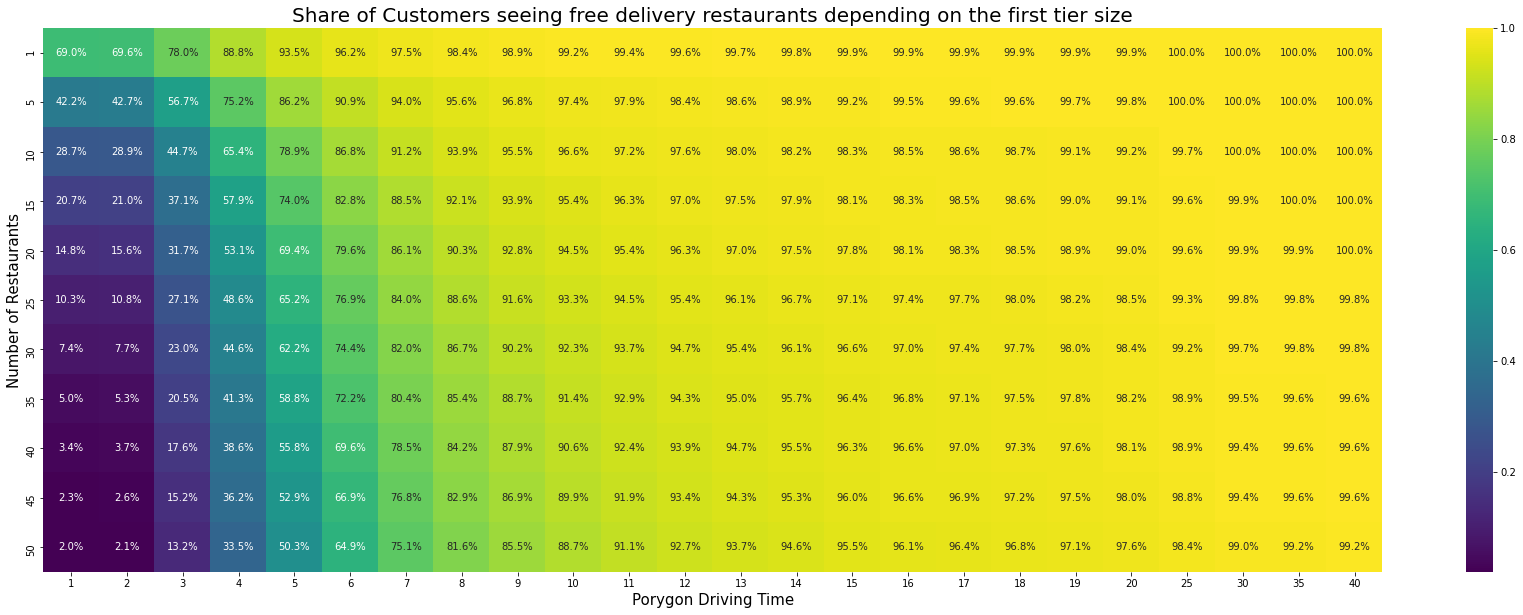

In [ ]:
plt.subplots(figsize=(30,10))
sns.heatmap(df2, fmt=".1%", annot=True, cmap='viridis')
plt.title('Share of Customers seeing free delivery restaurants depending on the first tier size', fontsize = 20)

plt.xlabel('Porygon Driving Time', fontsize = 15)
plt.ylabel('Number of Restaurants', fontsize = 15)

## Insight 2: The marginal effect of expanding porygon driving time areas

The pory_margin table shows how many restaurants a user see in HK in average with different porygon drive time value.


In [ ]:
pivot_cumsum.head()
pory_margin = pivot_cumsum.mean()
pory_margin = pd.DataFrame(pory_margin, columns = ["restaurants"])

pory_margin

,restaurants
porygon_dt,
1,3.831721
2,3.952631
3,9.017141
4,24.368814
5,47.798083
6,76.956502
7,110.169846
8,145.277302
9,179.808866


In [ ]:
row = list(pory_margin.index.values)
row = row[1:]
count_a_vals = pory_margin['restaurants'].values
delta = (count_a_vals[1:] - count_a_vals[:-1])/count_a_vals[:-1]

delta = pd.DataFrame(delta, columns = ["Marginal increase of Restaurant Number"])
delta["Increase to Porygon DT"] = row
delta

,Marginal increase of Restaurant Number,Increase to Porygon DT
0,0.031555,2
1,1.281301,3
2,1.702499,4
3,0.961445,5
4,0.610033,6
5,0.431586,7
6,0.318667,8
7,0.237694,9
8,0.184330,10
9,0.141842,11


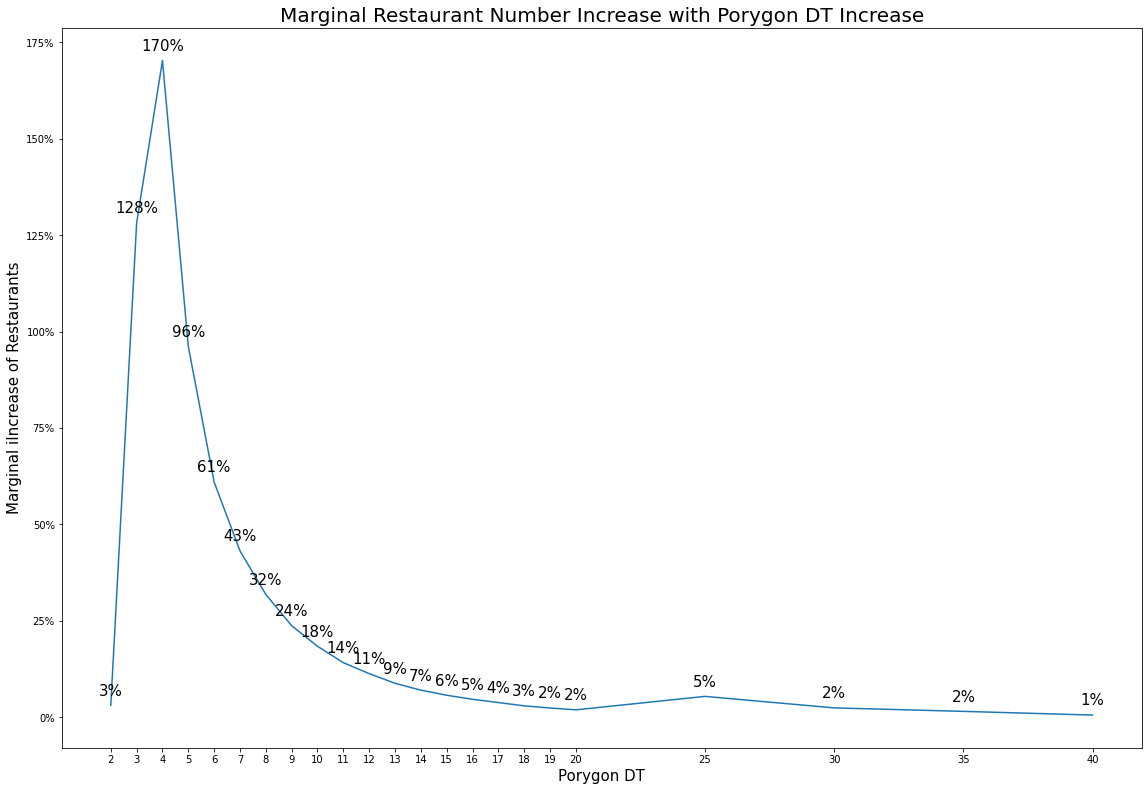

In [ ]:
#@title Marginal Restaurant Increase with Porygon DT increase
fig = plt.figure()
xs = delta["Increase to Porygon DT"]
ys = delta["Marginal increase of Restaurant Number"]
axes = fig.add_axes([0.1, 0.1, 2.5, 2.5])
axes.plot(xs, ys)
for x,y in zip(xs,ys):
    label = "{:.0f}%".format(y*100)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 15) # horizontal alignment can be left, right or center

axes.set_xlabel('Porygon DT', fontsize = 15)
axes.set_ylabel('Marginal iIncrease of Restaurants', fontsize = 15)
axes.set_title('Marginal Restaurant Number Increase with Porygon DT Increase', fontsize = 20)
axes.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
axes.set_xticks(delta['Increase to Porygon DT'])

plt.show()

## Insight 3: Map Visualisation



In [ ]:
query2 = """
SELECT
    st_x(st_geogfromtext(geohash_center)) as long
    , st_y(st_geogfromtext(geohash_center)) as lat
    , geohash
    , user_zone_id
    , zone_name
    , count(restaurant_id) as number_of_resutaurant
    , avg(weight) as weight
  FROM
    `temp.results_""" + country_code_tbd + """` a
    left join `temp.zone_""" + country_code_tbd + """` b
    on a.user_zone_id = b.zone_id
    group by 1,2,3,4, 5
    """

df_x = client.query(query2).to_dataframe()

query3 = """
SELECT
    distinct
    zone_id
    , zone_name
    , zone_shape
  FROM
   `temp.zone_""" + country_code_tbd + """` 
    """

zone = client.query(query3).to_dataframe()

In [ ]:
zone_geo = zone
zone_geo["zone_shape"] = zone_geo["zone_shape"].apply(wkt.loads)

In [ ]:
# map
map = folium.Map(location=[df_x["lat"].mean(), df_x["long"].mean()], width = "100%", height= "100%",zoom_start=12)

# add tiles to map
folium.raster_layers.TileLayer('Open Street Map').add_to(map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map)


style = {'fillColor': 'yellow', 'lineColor': 'grey'}

# add layer "zone shape" to map
zone_geo.apply(lambda row:folium.GeoJson(row["zone_shape"], name="zone_name",style_function=lambda x: style).add_to(map), axis=1)
#folium.GeoJson(zone_geo["zone_shape"], name="Zone Border").add_to(map)

# add layer control to show different maps
folium.LayerControl().add_to(map)

#draw = plugins.Draw(export=True)
#draw.add_to(map)

# add marker
df_x.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=row["weight"]/10,
                                              popup="Number of users: {},    Number of Restaurants to be seen: {},     Zone Name: {}".format(row["weight"], row["number_of_resutaurant"], row["zone_name"]),
                                              color='',
                                              fill_color="red")
                                              .add_to(map), axis=1)

# display map
map

Output hidden; open in https://colab.research.google.com to view.